# Task 2: Semantic similarity

## 1. WordNet similarity

In [19]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...


You can get a list of all synsets containing a specific word and also restrict the list by a part of speech.
Further, you can access the synset's `lemmas()` and the actual words using `name()`.

In [87]:
simlex_file = open("SimLex-999.txt", "r")
simlex_file.readline()  # column names

lines = simlex_file.readlines()
simlex_file.close()

simlex_data = []
sl_similarity = []

for line in lines:
  fields = line.split('\t')
  simlex_data.append((fields[0], fields[1], fields[2].casefold(), float(fields[3])))
  sl_similarity.append(float(fields[3]))
print(f"example of simplex_data contents = {simlex_data[0]}")

example of simplex_data contents = ('old', 'new', 'a', 1.58)


In [144]:
wn_similarity = []
for word1, word2, pos, sl_sim in simlex_data:
    synsets1 = wn.synsets(word1, pos=pos)
    synsets2 = wn.synsets(word2, pos=pos)

    wn_sim = 0.0
    for synset1 in synsets1:
        for synset2 in synsets2:
            similarity = synset1.path_similarity(synset2)
            if similarity > wn_sim:
                wn_sim = similarity

    print(f"{word1:15} {word2:15} {pos} {sl_sim:5.2} {wn_sim:5.2}")
    wn_similarity.append(wn_sim)

old             new             a   1.6  0.33
smart           intelligent     a   9.2  0.33
hard            difficult       a   8.8   1.0
happy           cheerful        a   9.6  0.33
hard            easy            a  0.95  0.33
fast            rapid           a   8.8  0.33
happy           glad            a   9.2   1.0
short           long            a   1.2  0.33
stupid          dumb            a   9.6  0.33
weird           strange         a   8.9  0.33
wide            narrow          a   1.0  0.33
bad             awful           a   8.4  0.33
easy            difficult       a  0.58  0.33
bad             terrible        a   7.8  0.33
hard            simple          a   1.4  0.33
smart           dumb            a  0.55  0.33
insane          crazy           a   9.6  0.33
happy           mad             a  0.95  0.33
large           huge            a   9.5  0.33
hard            tough           a   8.1   1.0
new             fresh           a   6.8   1.0
sharp           dull            a 

In [145]:
sl_words = set()
for word1, word2, _, _ in simlex_data:
    sl_words.add(word1)
    sl_words.add(word2)

wn_words = set(wn.words())

missed = sl_words - wn_words
if missed:
    print("Words missed", missed)
else:
    print("All SimLex words are a subset of WordNet")

All SimLex words are a subset of WordNet


## 2. FastText
Import the `fasttext` library and load the model.

*In my experience, it's faster to manually download/unzip the model and provide a path to the local file.*

In [74]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip install fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3986, done.
remote: Counting objects: 100% (1014/1014), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 3986 (delta 888), reused 854 (delta 830), pack-reused 2972
Receiving objects: 100% (3986/3986), 8.29 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (2526/2526), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=5a148109f850594c384760be0f1de922b8dd2b6deb673e4eeef31268329cddb7
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fastText


In [75]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model('cc.en.300.bin')

Import *cosine distance* from scipy. Note that it returns *1 – cos(u,v)*, since it is a distance (not similarity) measure.

In [137]:
from scipy.spatial.distance import cosine

ft_similarity = []
for word1, word2, _, sl_sim in simlex_data:
    vector1 = model[word1]
    vector2 = model[word2]

    ft_sim = 1 - cosine(vector1, vector2)
    ft_similarity.append(ft_sim)

    print(f"{word1:15} {word2:15} {pos} {sl_sim:5.2} {ft_sim:5.2}")

old             new             v   1.6  0.44
smart           intelligent     v   9.2   0.7
hard            difficult       v   8.8  0.63
happy           cheerful        v   9.6  0.55
hard            easy            v  0.95  0.49
fast            rapid           v   8.8  0.53
happy           glad            v   9.2  0.67
short           long            v   1.2  0.66
stupid          dumb            v   9.6  0.87
weird           strange         v   8.9  0.85
wide            narrow          v   1.0  0.54
bad             awful           v   8.4  0.67
easy            difficult       v  0.58  0.62
bad             terrible        v   7.8  0.73
hard            simple          v   1.4  0.34
smart           dumb            v  0.55  0.62
insane          crazy           v   9.6  0.79
happy           mad             v  0.95  0.32
large           huge            v   9.5  0.71
hard            tough           v   8.1  0.66
new             fresh           v   6.8  0.45
sharp           dull            v 

In [138]:
ft_words = set(wn.words())

missed = sl_words - ft_words
if missed:
    print("Words missed", missed)
else:
    print("All SimLex words are a subset of FastText")

All SimLex words are a subset of FastText


## 3. Kendall’s tau

In [133]:
import numpy as np
def normalize(float):
    return (float - np.min(float)) / (np.max(float) - np.min(float))

sl_similarity = normalize(sl_similarity)

Kendall's Tau SimLex & WordNet:    0.3534 7.74e-55
Kendall's Tau SimLex & FastText:   0.3301 7.74e-55


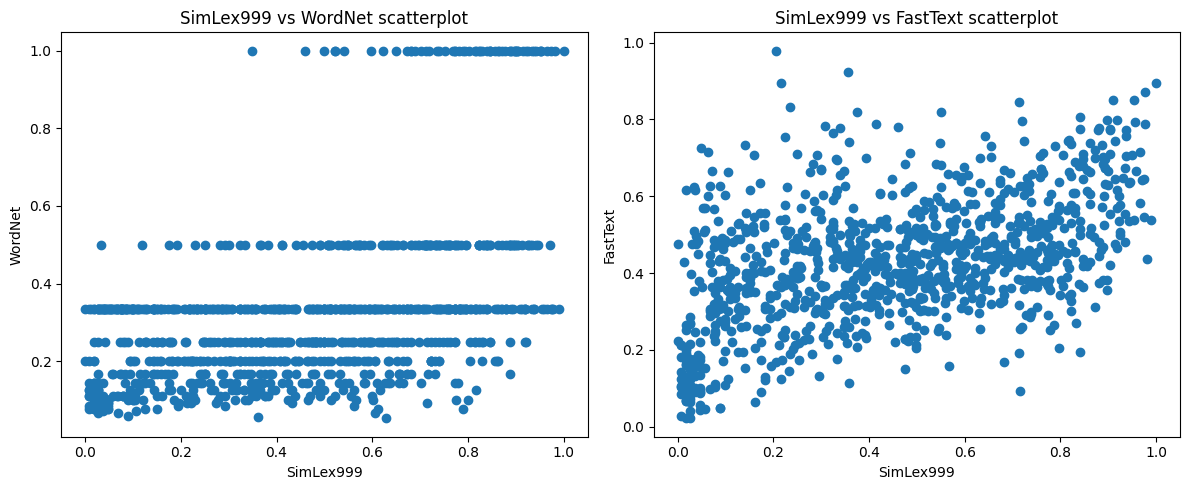

In [157]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# print(len(sl_similarity), len(wn_similarity), len(ft_similarity))

tau_wn, p_wn = stats.kendalltau(sl_similarity, wn_similarity)
tau_ft, p_ft = stats.kendalltau(sl_similarity, ft_similarity)

print(f"Kendall's Tau SimLex & WordNet:    {tau_wn:2.4} {p_wn:2.3}")
print(f"Kendall's Tau SimLex & FastText:   {tau_ft:2.4} {p_ft:2.3}")


plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(x=sl_similarity, y=wn_similarity)
plt.xlabel("SimLex999")
plt.ylabel("WordNet")
plt.title("SimLex999 vs WordNet scatterplot")

plt.subplot(122)
plt.scatter(x=sl_similarity, y=ft_similarity)
plt.xlabel("SimLex999")
plt.ylabel("FastText")
plt.title("SimLex999 vs FastText scatterplot")

plt.tight_layout()
plt.show()
